<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/store_sales/test.csv')
df_treino = pd.read_csv('/content/drive/MyDrive/store_sales/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store_sales/transactions.csv')
feriados = pd.read_csv('/content/drive/MyDrive/store_sales/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/store_sales/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store_sales/stores.csv')
sample = pd.read_csv('/content/drive/MyDrive/store_sales/sample_submission.csv')

In [4]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [5]:
transactions.isnull().any()

date            False
store_nbr       False
transactions    False
dtype: bool

In [6]:
transactions.isnull().values.any()

False

In [7]:
nulos = transactions.isnull().sum()  # Conta a quantidade de valores nulos (incluindo `nan`) em cada coluna
print(nulos)

date            0
store_nbr       0
transactions    0
dtype: int64


<ipython-input-8-ffa6d0a9e91d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novo['date'] = pd.to_datetime(df_novo['date'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnwa6nv6s/i3fij0so.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnwa6nv6s/avj7bfmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7782', 'data', 'file=/tmp/tmpnwa6nv6s/i3fij0so.json', 'init=/tmp/tmpnwa6nv6s/avj7bfmf.json', 'output', 'file=/tmp/tmpnwa6nv6s/prophet_model57nqa3h5/prophet_model-20240412005927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

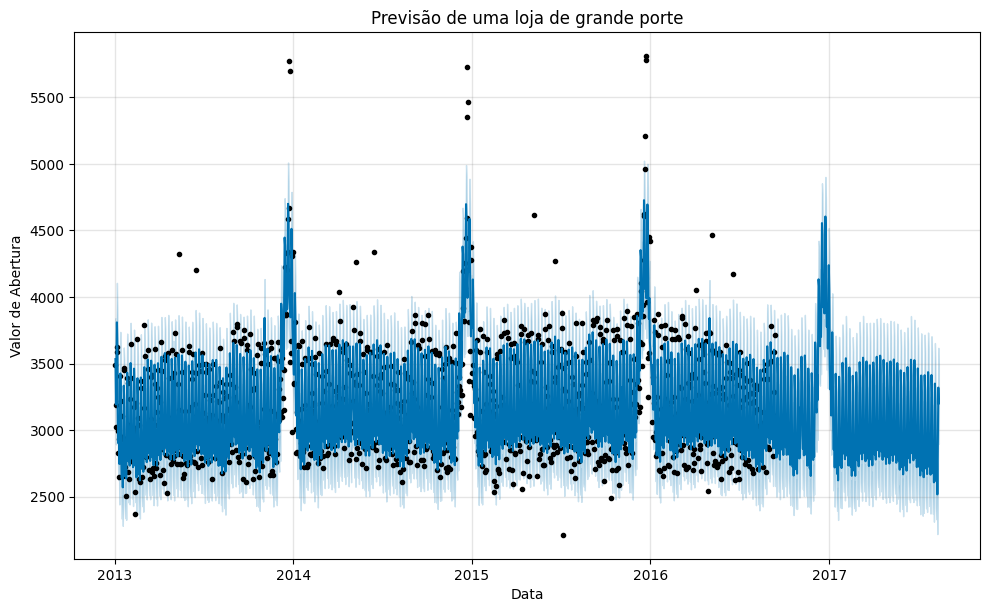

In [8]:
# Criar um novo DataFrame filtrando os valores da coluna "store_nbr"
df_novo = transactions[transactions['store_nbr'] == 3]
df_novo['date'] = pd.to_datetime(df_novo['date'])

# Renomeie as colunas para o formato esperado pelo Prophet
df_novo = df_novo.rename(columns={'date': 'ds', 'transactions': 'y'})

# Determine a proporção de divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino

# Calcule o índice de corte para dividir os dados
tamanho_treino = int(len(df_novo) * proporcao_treino)

# Separe os dados de treino e teste
df_train = df_novo.iloc[:tamanho_treino]  # Dados de treino
df_test = df_novo.iloc[tamanho_treino:]   # Dados de teste

# Crie e ajuste o modelo Prophet com os dados de treino
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='EC')
model.fit(df_train)

# Crie um DataFrame para prever as datas futuras com base no tamanho dos dados de teste
future = model.make_future_dataframe(periods=len(df_test))

# Faça previsões para as datas futuras
forecast = model.predict(future)

# Visualize as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de grande porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

In [9]:
# Avalie as previsões comparando com os dados de teste
test_results = forecast[['ds', 'yhat']].iloc[-len(df_test):]
comparison_df = df_test.set_index('ds').join(test_results.set_index('ds'))

# Verifique se há valores ausentes
print(comparison_df.isna().sum())

# Remova valores ausentes
comparison_df = comparison_df.dropna()


store_nbr    0
y            0
yhat         2
dtype: int64


In [10]:
print("Tamanho de 'y':", len(comparison_df['y']))
print("Tamanho de 'yhat':", len(comparison_df['yhat']))


Tamanho de 'y': 334
Tamanho de 'yhat': 334


In [11]:
print("Índices de 'y':", comparison_df['y'].index)
print("Índices de 'yhat':", comparison_df['yhat'].index)


Índices de 'y': DatetimeIndex(['2016-09-12', '2016-09-13', '2016-09-14', '2016-09-15',
               '2016-09-16', '2016-09-17', '2016-09-18', '2016-09-19',
               '2016-09-20', '2016-09-21',
               ...
               '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07',
               '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', name='ds', length=334, freq=None)
Índices de 'yhat': DatetimeIndex(['2016-09-12', '2016-09-13', '2016-09-14', '2016-09-15',
               '2016-09-16', '2016-09-17', '2016-09-18', '2016-09-19',
               '2016-09-20', '2016-09-21',
               ...
               '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07',
               '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', name='ds', length=334, freq=None)


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Assumindo que 'comparison_df' está definido e contém colunas 'y' (valores reais) e 'yhat' (previsões)
# e que não contém valores ausentes

# Calcule o RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))
print(f'RMSE: {rmse}')

# Calcule o MAE (Mean Absolute Error)
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
print(f'MAE: {mae}')

# Calcule o MAPE (Mean Absolute Percentage Error)
# Verifique se 'y' não contém valores zero para evitar divisão por zero no cálculo do MAPE
if not (comparison_df['y'] == 0).any():
    mape = mean_absolute_percentage_error(comparison_df['y'], comparison_df['yhat']) * 100
    print(f'MAPE: {mape}%')
else:
    print('MAPE não pôde ser calculado devido a valores zero em "y"')


RMSE: 285.7959073248549
MAE: 197.91518990179284
MAPE: 5.723734623203365%


In [13]:
if not (comparison_df['y'] == 0).any():
    mape = mean_absolute_percentage_error(comparison_df['y'], comparison_df['yhat']) * 100
    print(f'MAPE: {mape}%')

    # Calcule a acurácia como 100% menos o MAPE
    accuracy = 100 - mape
    print(f'Acurácia do modelo: {accuracy:.2f}%')
else:
    print('MAPE não pôde ser calculado devido a valores zero em "y"')

MAPE: 5.723734623203365%
Acurácia do modelo: 94.28%
